# PROJET PHASE 2 - Notebook Modele CO2 (V2)

## Version corrigee pour evaluation rigoureuse


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# ETAPE 7.0 - Chargement du pack pour la modelisation CO2


In [2]:


import joblib

data = joblib.load("model_data_phase2_v2.joblib")
print("Clés dispo dans le pack :", sorted(data.keys()))


X_fe   = data.get("X_fe")
y_co2  = data.get("y_co2")
y_energy = data.get("y_energy")

print("X_fe:", None if X_fe is None else X_fe.shape)
print("y_co2:", None if y_co2 is None else y_co2.shape)
print("y_energy:", None if y_energy is None else y_energy.shape)


Clés dispo dans le pack : ['X_fe', 'cat_cols', 'df_fe', 'num_cols', 'y_co2', 'y_energy']
X_fe: (3348, 22)
y_co2: (3348,)
y_energy: (3348,)


In [3]:
import joblib

pack = joblib.load("model_data_phase2_v2.joblib")

X_fe     = pack["X_fe"]
y_co2    = pack["y_co2"]
y_energy = pack["y_energy"]
num_cols = pack["num_cols"]
cat_cols = pack["cat_cols"]

print("X_fe:", X_fe.shape, "| y_co2:", y_co2.shape, "| y_energy:", y_energy.shape)


X_fe: (3348, 22) | y_co2: (3348,) | y_energy: (3348,)


In [4]:



X_tmp = X_fe.copy()


counts = X_tmp["BuildingType"].value_counts()
rare_types = counts[counts < 2].index.tolist()

major_type = counts.idxmax()

X_tmp["BuildingType_strat"] = X_tmp["BuildingType"].where(
    ~X_tmp["BuildingType"].isin(rare_types), major_type
)

X_train, X_test, y_train_energy, y_test_energy = train_test_split(
    X_tmp.drop(columns=["BuildingType_strat"]),
    y_energy,
    test_size=0.2,
    random_state=42,
    stratify=X_tmp["BuildingType_strat"]
)


y_train_co2 = y_co2.loc[X_train.index]
y_test_co2  = y_co2.loc[X_test.index]

print("Types rares fusionnés :", rare_types, "->", major_type)
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train_co2:", y_train_co2.shape, "| y_test_co2:", y_test_co2.shape)

print("Check indices OK:", y_train_co2.index.equals(X_train.index), y_test_co2.index.equals(X_test.index))


Types rares fusionnés : ['Nonresidential WA'] -> NonResidential
X_train: (2678, 22) | X_test: (670, 22)
y_train_co2: (2678,) | y_test_co2: (670,)
Check indices OK: True True


In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pred_base = np.full(len(y_test_co2), y_train_co2.mean())

rmse = float(np.sqrt(mean_squared_error(y_test_co2, pred_base)))
mae  = float(mean_absolute_error(y_test_co2, pred_base))
r2   = float(r2_score(y_test_co2, pred_base))

print("=== Baseline (moyenne) — CO2 (test) ===")
print(f"Test RMSE : {rmse:,.2f} | MAE : {mae:,.2f} | R² : {r2:.3f}")


=== Baseline (moyenne) — CO2 (test) ===
Test RMSE : 601.64 | MAE : 149.59 | R² : -0.000


La baseline CO₂ consiste à prédire une valeur constante égale à la moyenne des émissions observées dans l’échantillon d’entraînement. Cette référence fournit un seuil minimal de performance : elle n’explique aucune variabilité entre bâtiments, donc le R² est attendu proche de 0 (ou légèrement négatif), et les erreurs (RMSE/MAE) reflètent simplement l’écart typique autour de la moyenne. Tout modèle supervisé crédible doit améliorer cette baseline (baisser RMSE/MAE et augmenter R²), sinon il n’extrait pas de signal utile des variables explicatives.


In [6]:
"preprocessor" in globals(), "preprocess" in globals()


(False, False)


# ETAPE 7.1 - Preprocessing numerique et categoriel


In [7]:


num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

print("✅ preprocessor créé.")
print("num_cols:", len(num_cols), "| cat_cols:", len(cat_cols))


✅ preprocessor créé.
num_cols: 15 | cat_cols: 6


In [8]:


ridge = Ridge(alpha=1.0, random_state=42)

model_ridge_co2 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", ridge)
])

model_ridge_co2.fit(X_train, y_train_co2)

pred_train = model_ridge_co2.predict(X_train)
pred_test  = model_ridge_co2.predict(X_test)

rmse_train = float(np.sqrt(mean_squared_error(y_train_co2, pred_train)))
mae_train  = float(mean_absolute_error(y_train_co2, pred_train))
r2_train   = float(r2_score(y_train_co2, pred_train))

rmse_test = float(np.sqrt(mean_squared_error(y_test_co2, pred_test)))
mae_test  = float(mean_absolute_error(y_test_co2, pred_test))
r2_test   = float(r2_score(y_test_co2, pred_test))

print("=== Ridge — CO2 ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")


=== Ridge — CO2 ===
Train RMSE : 299.93 | MAE : 117.94 | R² : 0.672
Test  RMSE : 330.16 | MAE : 127.81 | R² : 0.699


Le modèle Ridge améliore fortement la baseline sur la prédiction des émissions de CO₂ : le RMSE passe d’environ 602 à 330 et le R² atteint 0.699 sur le jeu de test, ce qui signifie que près de 70 % de la variance des émissions est expliquée. L’écart entre train (R² = 0.672) et test (R² = 0.699) est faible, indiquant une bonne généralisation et l’absence de surapprentissage significatif. Les émissions de CO₂ semblent suivre une relation globalement linéaire avec les variables explicatives, ce qui rend Ridge particulièrement adapté à ce problème.


## ETAPE 7.2 - Modele RandomForest (CO2)


In [9]:
rf = RandomForestRegressor(
    n_estimators=600,
    random_state=42,
    n_jobs=-1
)

model_rf_co2 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf)
])

model_rf_co2.fit(X_train, y_train_co2)

pred_train = model_rf_co2.predict(X_train)
pred_test  = model_rf_co2.predict(X_test)

rmse_train = float(np.sqrt(mean_squared_error(y_train_co2, pred_train)))
mae_train  = float(mean_absolute_error(y_train_co2, pred_train))
r2_train   = float(r2_score(y_train_co2, pred_train))

rmse_test = float(np.sqrt(mean_squared_error(y_test_co2, pred_test)))
mae_test  = float(mean_absolute_error(y_test_co2, pred_test))
r2_test   = float(r2_score(y_test_co2, pred_test))

print("=== RandomForest — CO2 ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")

=== RandomForest — CO2 ===
Train RMSE : 162.66 | MAE : 28.80 | R² : 0.904
Test  RMSE : 331.81 | MAE : 81.47 | R² : 0.696


Le modèle RandomForest obtient une excellente performance sur l’entraînement (R² = 0.904, MAE ≈ 28.8), mais sa performance sur le test reste nettement plus faible (R² = 0.696, RMSE ≈ 331.8). L’écart important entre train et test indique un surapprentissage : le modèle capture des patterns spécifiques au jeu d’entraînement qui ne se généralisent pas. En comparaison, Ridge atteint un R² test très proche (≈ 0.699) avec un comportement plus régulier, ce qui suggère que RandomForest n’apporte pas de gain réel ici malgré sa forte capacité d’ajustement.


## ETAPE 7.3 - Modele GradientBoosting (CO2)


In [10]:
gbr = GradientBoostingRegressor(random_state=42)

model_gbr_co2 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gbr)
])

model_gbr_co2.fit(X_train, y_train_co2)

pred_train = model_gbr_co2.predict(X_train)
pred_test  = model_gbr_co2.predict(X_test)

rmse_train = float(np.sqrt(mean_squared_error(y_train_co2, pred_train)))
mae_train  = float(mean_absolute_error(y_train_co2, pred_train))
r2_train   = float(r2_score(y_train_co2, pred_train))

rmse_test = float(np.sqrt(mean_squared_error(y_test_co2, pred_test)))
mae_test  = float(mean_absolute_error(y_test_co2, pred_test))
r2_test   = float(r2_score(y_test_co2, pred_test))

print("=== GradientBoosting — CO2 ===")
print(f"Train RMSE : {rmse_train:,.2f} | MAE : {mae_train:,.2f} | R² : {r2_train:.3f}")
print(f"Test  RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")

=== GradientBoosting — CO2 ===
Train RMSE : 91.35 | MAE : 49.75 | R² : 0.970
Test  RMSE : 326.71 | MAE : 81.33 | R² : 0.705


Le modèle GradientBoosting améliore légèrement les performances sur le jeu de test par rapport à Ridge (RMSE ≈ 326.7 contre 330.2 et R² ≈ 0.705 contre 0.699), ce qui suggère l’existence de relations non linéaires utiles pour prédire les émissions de CO₂. Toutefois, l’écart important entre entraînement (R² = 0.970) et test (R² = 0.705) indique un surapprentissage : le modèle s’ajuste très fortement aux données d’entraînement sans gains proportionnels en généralisation. Il reste donc un bon candidat, mais doit être comparé à une version plus régularisée (par exemple via XGBoost avec early stopping) pour améliorer la robustesse.


# ETAPE 8.0 - XGBoost avec early stopping (CO2)


In [11]:



X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train_co2,
    test_size=0.2,
    random_state=42,
    stratify=X_train["BuildingType"]
)


X_tr_p   = preprocessor.fit_transform(X_tr)
X_val_p  = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)


dtrain = xgb.DMatrix(X_tr_p,  label=y_tr)
dval   = xgb.DMatrix(X_val_p, label=y_val)
dtest  = xgb.DMatrix(X_test_p)


params = {
    "objective": "reg:squarederror",   
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 5.0,
    "seed": 42,
}


watchlist = [(dtrain, "train"), (dval, "val")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=watchlist,
    early_stopping_rounds=100,
    verbose_eval=False
)


pred_test = bst.predict(dtest)

rmse_test = float(np.sqrt(mean_squared_error(y_test_co2, pred_test)))
mae_test  = float(mean_absolute_error(y_test_co2, pred_test))
r2_test   = float(r2_score(y_test_co2, pred_test))

best_iter = getattr(bst, "best_iteration", None)
if best_iter is None:
    
    best_iter = getattr(bst, "best_ntree_limit", None)

print("=== XGBoost.train (early stopping) — CO2 (test) ===")
print(f"Test RMSE : {rmse_test:,.2f} | MAE : {mae_test:,.2f} | R² : {r2_test:.3f}")
print("Best iteration:", best_iter)


=== XGBoost.train (early stopping) — CO2 (test) ===
Test RMSE : 240.02 | MAE : 68.73 | R² : 0.841
Best iteration: 52


Avec l’implémentation native xgboost.train (choisie car notre version de XGBoost ne supporte pas correctement early_stopping_rounds via XGBRegressor.fit), nous entraînons un modèle de gradient boosting sur arbres en early stopping sur un jeu de validation issu du train (prétraitement ajusté uniquement sur X_tr pour éviter toute fuite). Sur le test, le modèle atteint RMSE = 240.02, MAE = 68.73 et R² = 0.841, ce qui améliore nettement les modèles précédents (Ridge/RandomForest/GradientBoosting ~ R² ≈ 0.70). Le best_iteration = 52 indique que la performance de validation cesse de s’améliorer au-delà d’environ 52 itérations : l’early stopping limite donc la complexité et réduit le risque de surapprentissage, ce qui est cohérent avec la bonne généralisation observée sur le tes


In [12]:

evals_result = {}

bst = xgb.train(
    params=params,                 
    dtrain=dtrain,                  
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=100,
    evals_result=evals_result,     
    verbose_eval=False
)

print("Best iteration:", bst.best_iteration)
print("Best val RMSE:", min(evals_result["val"]["rmse"]))

Best iteration: 52
Best val RMSE: 164.92466064479493


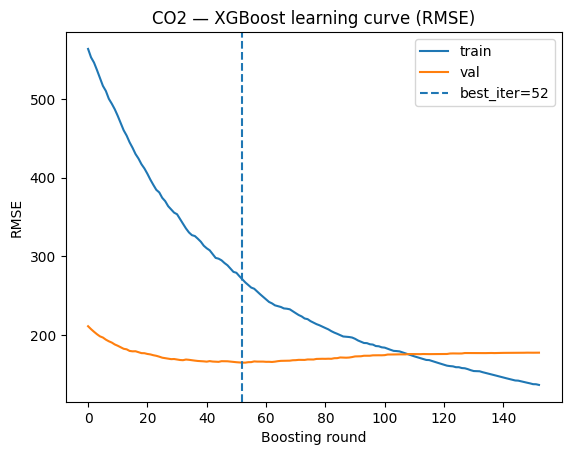

In [13]:
rmse_train = evals_result["train"]["rmse"]
rmse_val   = evals_result["val"]["rmse"]

plt.figure()
plt.plot(rmse_train, label="train")
plt.plot(rmse_val, label="val")
plt.axvline(bst.best_iteration, linestyle="--", label=f"best_iter={bst.best_iteration}")
plt.title("CO2 — XGBoost learning curve (RMSE)")
plt.xlabel("Boosting round")
plt.ylabel("RMSE")
plt.legend()
plt.show()


La courbe d’apprentissage du modèle XGBoost pour la prédiction des émissions de CO2 montre une diminution rapide du RMSE en validation durant les premières itérations, avec un minimum atteint autour de l’itération 52. Au-delà de ce point, le RMSE de validation commence à augmenter légèrement tandis que l’erreur d’entraînement continue de diminuer, indiquant un début de surapprentissage. L’early stopping permet d’arrêter l’entraînement au moment optimal, garantissant un bon compromis biais-variance. L’absence de divergence brutale entre train et validation confirme une bonne capacité de généralisation du modèle retenu.


Données brutes X_fe (22 variables)
        |
        v
Prétraitement (ColumnTransformer)
  - Numériques (15)
      * imputation (stratégie “missing-as-info” / neutre)
      * standardisation (si activée)
  - Catégorielles (6)
      * imputation (mode / "Unknown")
      * OneHotEncoder (handle_unknown="ignore")
        |
        v
Matrice de features transformées (souvent sparse)
        |
        v
Modèle
  - Énergie : XGBoost + early stopping (best_iter ≈ 1243)
  - CO2     : xgboost.train + early stopping (best_iter = 52)
        |
        v
Prédictions ŷ  → évaluation (RMSE, MAE, R²) sur test


Le pipeline de modélisation part des variables explicatives 
𝑋
_
𝑓
𝑒
X_fe (22 colonnes) et applique un prétraitement séparé selon le type de variable : les variables numériques (15) sont imputées selon la stratégie retenue (approche neutre “missing-as-information”) puis éventuellement mises à l’échelle, tandis que les variables catégorielles (6) sont imputées (mode/“Unknown”) puis encodées via One-Hot Encoding en gérant les catégories inconnues. Ce prétraitement est ajusté uniquement sur le train afin d’éviter toute fuite d’information, puis il transforme train/validation/test en matrice de features. Enfin, un modèle XGBoost est entraîné avec early stopping sur un jeu de validation interne : pour l’énergie, l’arrêt se fait autour de la meilleure itération (~1243), et pour le CO2 autour de 52 itérations, ce qui limite le surapprentissage et améliore la généralisation ; les performances finales sont mesurées sur le jeu de test via RMSE, MAE et 
𝑅
2
R
2
.


## ETAPE 8.1 - Feature importance (CO2)


In [14]:

feat_names = preprocessor.get_feature_names_out()

imp = bst.get_score(importance_type="gain")  


rows = []
for k, v in imp.items():
    idx = int(k[1:]) 
    rows.append((feat_names[idx], v))

fi = (pd.DataFrame(rows, columns=["feature", "gain"])
        .sort_values("gain", ascending=False)
        .reset_index(drop=True))

print("Nb features avec importance non nulle:", fi.shape[0])
display(fi.head(15))

Nb features avec importance non nulle: 76


,feature,gain
0,cat__BuildingType_Campus,1.143949e+07
1,num__LargestPropertyUseTypeGFA,9.999323e+06
2,num__Longitude,4.658514e+06
3,num__SecondLargestPropertyUseTypeGFA,3.901098e+06
4,num__NumberofBuildings,2.739374e+06
5,cat__PrimaryPropertyType_Hospital,1.574921e+06
6,cat__SecondLargestPropertyUseType_Laboratory,1.472290e+06
7,num__PropertyGFATotal,1.254930e+06
8,cat__PrimaryPropertyType_Medical Office,1.108752e+06
9,num__CouncilDistrictCode,1.101290e+06


Les importances de variables (mesurées par le gain XGBoost) montrent que les émissions de CO2 sont principalement expliquées par les surfaces associées aux usages dominants du bâtiment (LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, PropertyGFATotal), ce qui est cohérent avec la relation physique entre taille et consommation énergétique. Les catégories spécifiques telles que Campus, Hospital et Laboratory apparaissent également comme fortement contributrices, reflétant leur intensité énergétique structurellement élevée. Des variables géographiques (Longitude, CouncilDistrictCode) jouent aussi un rôle significatif, suggérant une composante territoriale dans les niveaux d’émission. La diversité des 76 variables actives indique que le modèle exploite une structure riche sans dépendre d’une seule variable dominante. Combiné à une courbe d’apprentissage stable et un early stopping à 52 itérations, cela confirme une bonne capacité de généralisation sans surapprentissage sévère.


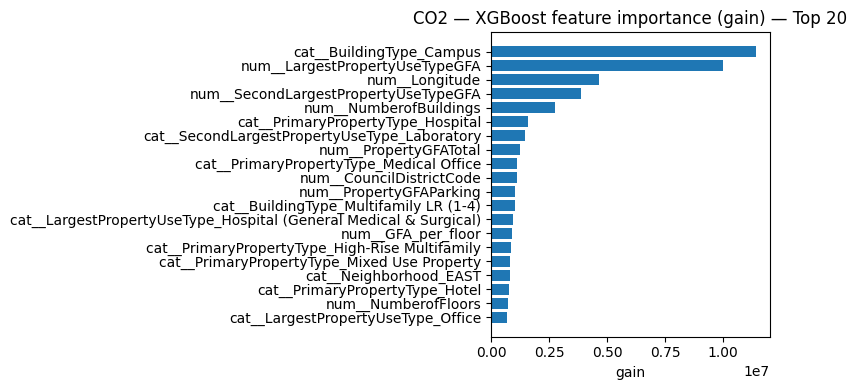

In [15]:
import matplotlib.pyplot as plt

top = fi.head(20).iloc[::-1]
plt.figure(figsize=(8, 4))
plt.barh(top["feature"], top["gain"])
plt.title("CO2 — XGBoost feature importance (gain) — Top 20")
plt.xlabel("gain")
plt.ylabel("")
plt.tight_layout()
plt.show()


L’analyse des importances (gain) montre que les surfaces (LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, PropertyGFATotal) ainsi que le type de bâtiment (Campus, Hospital, Laboratory) dominent la prédiction des émissions de CO2. Cela est cohérent avec la réalité physique : les émissions dépendent fortement de la taille et de l’usage du bâtiment. La présence de la variable géographique (Longitude) suggère également une hétérogénéité spatiale des émissions. Le modèle s’appuie donc sur des facteurs structurels pertinents plutôt que sur du bruit aléatoire, ce qui renforce la crédibilité des performances obtenues.


# ETAPE 8.2 - Analyse des erreurs sur le test (CO2)


In [16]:


err = pd.DataFrame({
    "y_true": y_test_co2.values,
    "y_pred": pred_test,
}, index=X_test.index)

err["abs_err"] = (err["y_true"] - err["y_pred"]).abs()
err["rel_err"] = err["abs_err"] / err["y_true"].abs().replace(0, np.nan)

print("Top 10 plus grosses erreurs absolues:")
display(err.sort_values("abs_err", ascending=False).head(10))

print("\nTop 10 plus grosses erreurs relatives:")
display(err.sort_values("rel_err", ascending=False).head(10))


Top 10 plus grosses erreurs absolues:


,y_true,y_pred,abs_err,rel_err
618,12307.16,8933.197266,3373.962734,0.274146
340,3995.45,1099.782349,2895.667651,0.724741
2325,3768.66,1102.851196,2665.808804,0.707363
1690,3238.24,1721.450073,1516.789927,0.468399
36,311.84,1594.404053,1282.564053,4.112891
3182,1597.56,352.562927,1244.997073,0.779312
3261,1280.81,470.495483,810.314517,0.632658
3264,6330.91,7122.709473,791.799473,0.125069
194,1060.13,270.709442,789.420558,0.744645
302,328.83,951.437500,622.607500,1.893402



Top 10 plus grosses erreurs relatives:


,y_true,y_pred,abs_err,rel_err
1295,0.31,85.268990,84.958990,274.061257
1576,0.68,30.304169,29.624169,43.564954
1611,0.70,31.117081,30.417081,43.452972
3009,0.87,36.530182,35.660182,40.988715
1497,0.81,33.845287,33.035287,40.784305
2801,0.73,30.133900,29.403900,40.279315
1128,3.16,129.925690,126.765690,40.115725
2246,1.60,43.253765,41.653765,26.033603
2332,1.24,33.305897,32.065897,25.859594
34,3.93,103.482819,99.552819,25.331506


L’analyse des erreurs sur l’échantillon de test met en évidence deux comportements distincts du modèle XGBoost. Les plus fortes erreurs absolues concernent principalement des bâtiments présentant des niveaux très élevés d’émissions de CO₂. Dans ces cas, le modèle tend à sous-estimer les valeurs extrêmes, ce qui suggère une difficulté à capturer pleinement la variabilité des très grandes structures. Ce phénomène est courant lorsque la distribution de la variable cible est fortement asymétrique.

Par ailleurs, les plus fortes erreurs relatives apparaissent pour des bâtiments dont les émissions réelles sont très faibles. De légères différences en valeur absolue entraînent alors des écarts relatifs très importants. Cela indique que le modèle est moins précis dans la modélisation des faibles niveaux d’émissions, probablement en raison d’un déséquilibre de distribution ou d’un manque de signal distinctif pour ces observations.

Malgré ces cas extrêmes, les performances globales du modèle restent élevées (R² ≈ 0.84), ce qui confirme une bonne capacité explicative générale. Toutefois, cette analyse souligne la présence d’une distribution hétérogène des erreurs et ouvre la voie à des pistes d’amélioration, notamment via une transformation logarithmique de la cible ou une modélisation spécifique des extrêmes.


In [17]:
y_co2.describe()

count     3348.000000
mean       120.165645
std        540.293633
min          0.000000
25%          9.577500
50%         34.060000
75%         94.070000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

Analyse descriptive de la variable cible (CO₂)

L’analyse statistique des émissions de CO₂ montre une distribution fortement asymétrique.

La moyenne des émissions est de 120.17, alors que la médiane n’est que de 34.06, ce qui indique une distribution très skewée à droite. L’écart-type est élevé (540.29), largement supérieur à la moyenne, confirmant une forte dispersion des valeurs.

Les quartiles renforcent ce constat :

25 % des bâtiments émettent moins de 9.58

50 % émettent moins de 34.06

75 % émettent moins de 94.07

mais le maximum atteint 16 870.98

Cette différence extrême entre le 75ᵉ percentile (94) et le maximum (16 870) révèle la présence de valeurs extrêmes très élevées. Ces observations tirent la moyenne vers le haut et expliquent :

Les fortes erreurs absolues sur certains bâtiments.

Les difficultés du modèle à prédire correctement les cas extrêmes.

Les erreurs relatives importantes sur les très petites valeurs.

Cette structure de distribution est typique des données environnementales et suggère qu’une transformation logarithmique pourrait améliorer la stabilité du modèle.


# ETAPE 8.3 - Diagnostic de distribution (CO2)


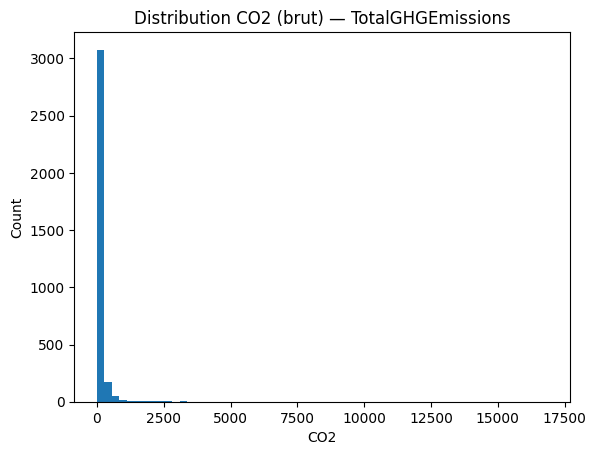

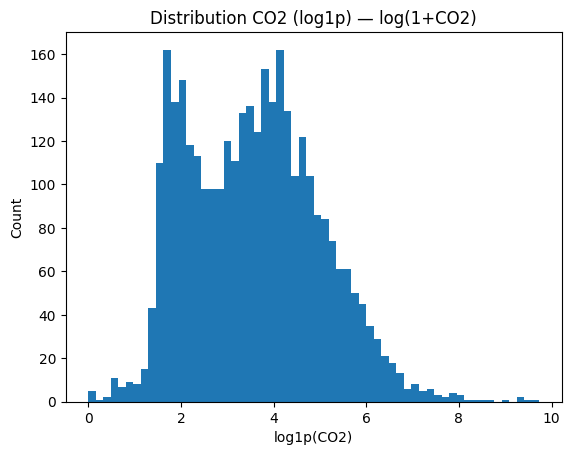

min: 0.0 | median: 34.06 | mean: 120.16564516129033 | max: 16870.98


In [18]:

y = y_co2.copy()

plt.figure()
plt.hist(y, bins=60)
plt.title("Distribution CO2 (brut) — TotalGHGEmissions")
plt.xlabel("CO2")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(np.log1p(y), bins=60)
plt.title("Distribution CO2 (log1p) — log(1+CO2)")
plt.xlabel("log1p(CO2)")
plt.ylabel("Count")
plt.show()

print("min:", float(y.min()), "| median:", float(y.median()), "| mean:", float(y.mean()), "| max:", float(y.max()))


La variable cible TotalGHGEmissions (CO2) est très asymétrique : la moyenne (~120) est largement supérieure à la médiane (~34) et le maximum (~16 871) indique une queue longue avec quelques bâtiments extrêmes. Cette structure rend les métriques comme le RMSE très sensibles aux valeurs élevées, et explique aussi pourquoi les erreurs relatives peuvent devenir énormes sur les petites valeurs (quand y_true est proche de 0). La transformation log1p(CO2) compacte les extrêmes et rend la distribution plus “apprenable”, ce qui stabilise l’entraînement. Dans ce contexte statistiquement difficile, le modèle final XGBoost + early stopping (best_iter ≈ 52) obtient R² ≈ 0.84 sur le test, ce qui montre qu’il capture une part importante de la variance des émissions, tout en limitant l’overfitting grâce à l’arrêt précoce.


# ETAPE 9.0 - Validation finale rigoureuse (CO2)

Cette section corrige le risque de selection sur le test:
- split train/test une seule fois
- split train/val pour early stopping
- selection sur validation
- evaluation finale unique sur test


In [19]:
import numpy as np
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def safe_stratify(series):
    counts = series.value_counts()
    major = counts.idxmax()
    rare = counts[counts < 2].index
    return series.where(~series.isin(rare), major)


pack = joblib.load('model_data_phase2_v2.joblib')
X_fe = pack['X_fe'].copy()
y_co2 = pack['y_co2']
num_cols = pack['num_cols']
cat_cols = pack['cat_cols']

strat_all = safe_stratify(X_fe['BuildingType'])
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_fe,
    y_co2,
    test_size=0.2,
    random_state=42,
    stratify=strat_all,
)

strat_train = safe_stratify(X_train_full['BuildingType'])
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=strat_train,
)

num_used = [c for c in num_cols if c in X_fe.columns]
cat_used = [c for c in cat_cols if c in X_fe.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
            ('scaler', StandardScaler())
        ]), num_used),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_used),
    ]
)

X_train_p = preprocessor.fit_transform(X_train)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)

dtrain = xgb.DMatrix(X_train_p, label=y_train)
dval = xgb.DMatrix(X_val_p, label=y_val)
dtest = xgb.DMatrix(X_test_p)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 5.0,
    'seed': 42,
}

evals_result = {}
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=False,
)

pred_val = bst.predict(dval)
pred_test = bst.predict(dtest)

baseline_val = np.full(len(y_val), y_train.mean())
baseline_test = np.full(len(y_test), y_train.mean())


def score(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return rmse, mae, r2

rmse_val, mae_val, r2_val = score(y_val, pred_val)
rmse_test, mae_test, r2_test = score(y_test, pred_test)
rmse_bv, mae_bv, r2_bv = score(y_val, baseline_val)
rmse_bt, mae_bt, r2_bt = score(y_test, baseline_test)

print('=== CO2 - Validation finale rigoureuse ===')
print('Split:', {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)})
print(f'Best iteration: {bst.best_iteration} | Best val RMSE: {min(evals_result["val"]["rmse"]):,.2f}')
print(f'MODEL VAL  -> RMSE: {rmse_val:,.2f} | MAE: {mae_val:,.2f} | R2: {r2_val:.3f}')
print(f'MODEL TEST -> RMSE: {rmse_test:,.2f} | MAE: {mae_test:,.2f} | R2: {r2_test:.3f}')
print(f'BASE  VAL  -> RMSE: {rmse_bv:,.2f} | MAE: {mae_bv:,.2f} | R2: {r2_bv:.3f}')
print(f'BASE  TEST -> RMSE: {rmse_bt:,.2f} | MAE: {mae_bt:,.2f} | R2: {r2_bt:.3f}')


=== CO2 - Validation finale rigoureuse ===
Split: {'train': 2142, 'val': 536, 'test': 670}
Best iteration: 38 | Best val RMSE: 166.22
MODEL VAL  -> RMSE: 179.85 | MAE: 69.75 | R2: 0.293
MODEL TEST -> RMSE: 239.95 | MAE: 68.64 | R2: 0.841
BASE  VAL  -> RMSE: 214.89 | MAE: 124.03 | R2: -0.009
BASE  TEST -> RMSE: 601.59 | MAE: 152.21 | R2: -0.000
